In [1]:
import pandas as pd
from gensim import corpora, models, similarities
from nltk.corpus import stopwords
import re
import numpy as np
from scipy import special,stats
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:
f = '/Users/jingy/Desktop/ao3/data/sherlock_current_wtext_samemonth.csv'

In [3]:
data = pd.read_csv(f)

In [4]:
df = data

In [5]:
df = df.astype(str)
df = df.groupby(['Archive_Warnings', 'Author', 'Chapters', 'Characters', 'Fandoms', 'Hits', 'Kudos', 'Language', 'PublishDate',
                 'Rating','Summary', 'Title', 'Words'])['Text'].apply(','.join).reset_index()

### Run lda on texts.

In [6]:
df = df[df['Text'].astype('str').str.len() > 500]

In [7]:
df = df.drop_duplicates('Text')

In [8]:
def preprocess(df, st):
    #pre-processing
    #input: a slice of the original df
    #output: a list of lists each containing cleaned words from a work
    text = df[['Text']]
    text['Text'] = text['Text'].str.replace('A', '')
    text = text.Text.str.lower().str.split()
    text_cleaned = []
    for line in text:
        line = [re.sub(r'[^A-Za-z0-9]+', '', str(word)) for word in line]
        line = [word for word in line if len(word) > 1 and not word.isdigit() and word not in st]
        text_cleaned.append(line)
    return text_cleaned

In [9]:
def create_df_time(df, time):
    return df[df.PublishDate.str[:7] == time]

In [10]:
timelist = df.PublishDate.drop_duplicates().tolist()
timelist = [str(i)[:7] for i in timelist]
timelist = sorted(list(set(timelist)))

In [ ]:
st = stopwords.words('english')

In [ ]:
text = preprocess(df, st)
id2word = corpora.dictionary.Dictionary(text)
corpus = [id2word.doc2bow(t) for t in text]
lda = models.LdaMulticore(corpus=corpus,id2word=id2word,num_topics=40)

In [ ]:
gamma_all = {}
kudos_all = {}
for month in timelist:
    gammas = []
    df_ts = create_df_time(df, month)
    kudos = df_ts.Kudos.astype(float).tolist()
    text = preprocess(df_ts, st)
    for i in range(len(text)):
        gammas.append(lda.get_document_topics(id2word.doc2bow(text[i]), minimum_probability = 0))
    gamma_all[month] = gammas
    kudos_all[month] = kudos

###Calculate KL of a work from the "standard" work.

In [20]:
def calc_kl(p, q):
    return sum([p[i]*(np.log2(p[i]/q[i])) for i in range(len(p))])

In [23]:
def calc_std_dist(gamma_list): 
    gamma_list_flat = []
    for i in gamma_list:
        for j in i:
            gamma_list_flat.append(j)
                    
    ave = {}
    for n in range(40):
        t = []
        for i in gamma_list_flat:
            if i[0] == n:
                t.append(i[1])
        ave[n] = sum(t)/float(len(gamma_list))

    return ave.values()

In [24]:
cor_all = []
count = 0
for month in gamma_all:
    std_dist = calc_std_dist(gamma_all.get(month))
    kls = []
    for i in gamma_all.get(month):
        kls.append(calc_kl([j[1] for j in i], std_dist))
    for k in kudos_all[month]:
        if np.isnan(k):
            kudos_all[month][kudos_all[month].index(k)] = 0
            
    cor_all.append(stats.pearsonr(kls, kudos_all[month])[0])

In [35]:
np.average(cor_all)
# (np.var(cor_all)/len(cor_all))**0.5

-0.21403487568799343

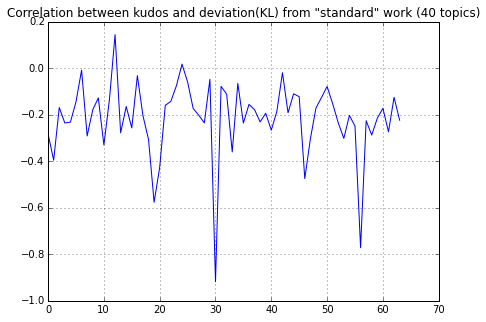

In [26]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(cor_all)
plt.grid()
ax.set_title('Correlation between kudos and deviation(KL) from "standard" work (40 topics)')

In [27]:
kl_ave = []
for month in gamma_all:
    std_dist = calc_std_dist(gamma_all.get(month))
    kls = []
    for i in gamma_all.get(month):
        kls.append(calc_kl([j[1] for j in i], std_dist))
    kl_ave.append(np.average(kls))

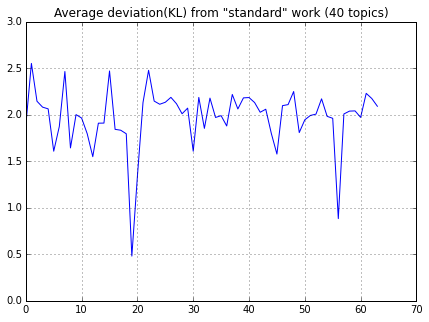

In [32]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(kl_ave)
ax.set_title('Average deviation(KL) from "standard" work (40 topics)')
plt.grid()

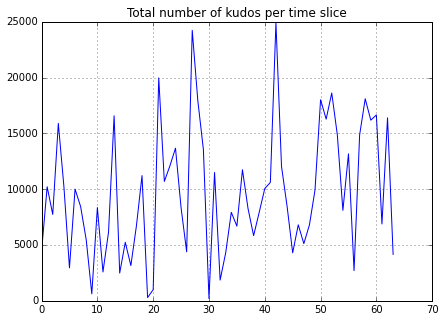

In [219]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot([sum(k) for k in kudos_all.values()])
ax.set_title('Total number of kudos per time slice')
plt.grid()

In [220]:
work_count = []
for month in timelist:
    df_ts = create_df_time(df, month)
    work_count.append(len(df_ts))

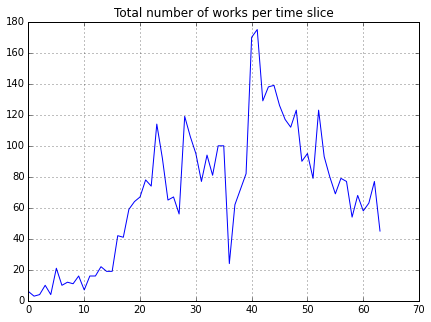

In [221]:
fig, ax = plt.subplots(figsize = (7, 5))
ax.plot(work_count)
ax.set_title('Total number of works per time slice')
plt.grid()